# Milestone 2 - SECOM Manufacturing

## Author - Lukas Fiorio

## Instructions

- Read and merge data
- Clean and prepare data 
- Handle class imbalance problem
- Apply feature reduction
- Build and evaluate predictive models (decision tree, ensemble, SVM)
- Summarize/describe findings

## Introduction

In this project we build upon the feature selection that we started in Milestone 1.  Our goal is to predict manufacturing failures based on sensor readings that monitor the manufacturing process.

In Milestone 1 we used various feature selection techniques to reduce the dimensionality of our data to just the most useful predictors.

In this project, we go further to split our data into Train-Validate-Test sets for model evaluation using Decision Tree, Random Forest, and SVM classifier models.  We explore several hyper parameters for each and compare the success of each model.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib

# SFS stepwise selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.evaluate import PredefinedHoldoutSplit

# feature reduction
from sklearn.feature_selection import mutual_info_regression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# accuracy metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# multiple imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# classifiers
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as rfc

from joblib import dump, load # save/load model fitted models 
from itertools import product # cartesian product

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns

## Read and merge data

This was handled and explained in more detail in Milestone 1.  Below is a summary of the steps taken:

- Stored data urls
- Inspection showed features in a space-delimited (`" "`) txt file.  Loaded them into a dataframe.
- Labels needed more customized loading (line-by-line into a list, parsing out extra fields and characters).
- Merged features and labels together into a dataframe.

In [3]:
# data sources, for loading
features_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

# load features into df
features = np.loadtxt(features_url)
features_df = pd.DataFrame(features)

# load labels data into list
labels_txt = urllib.request.urlopen(labels_url).read().splitlines()
labels = [] # empty list to store labels

# loop through labels, cleaning/splitting & appending to new list
for i in labels_txt:
    i = i.decode("utf-8").replace('"', '').split()
    labels.append(i) # append to list

# convert list to df
labels_df = pd.DataFrame(labels, columns = ['target', 'date', 'time'])

# properly type each column
labels_df['target'] = labels_df['target'].astype('int')
labels_df['date'] = pd.to_datetime(labels_df['date'])
labels_df['time'] = pd.to_timedelta(labels_df['time'])

# concat features & labels into df
secom_df = pd.concat([features_df, labels_df], axis=1)

## Clean and Prepare Data

In Milestone 1, we walked through several steps we took to clean our data (reducing the feature count in the process) *before* addressing class imbalance and feature selection methods.

Here, we've condensed those steps down.

- Drop duplicate columns \[104\] (and convert object columns back to numeric)
- Drop columns with only a single unique value \[12\]
- Drop columns with 80%+ null values \[8\]

In [4]:
### drop duplicate columns ###
secom_df = secom_df.T.drop_duplicates().T

# convert object columns back to numeric
obj_cols = secom_df.select_dtypes('object').columns
secom_df[obj_cols] = secom_df[obj_cols].astype(float)
secom_df['target'] = secom_df['target'].astype(int)

### drop columns w 1 unique val ###

# count of unique values by column
unique_val_cnt = secom_df.nunique().tolist()

# flag & drop columns with only 1 unique value
redundant_cols = secom_df.columns[np.where(np.array(unique_val_cnt)==1)[0]]
secom_df = secom_df.drop(redundant_cols, axis = 1)

### drop columns w 80%+ nulls ###

# flag & drop columns w >80% null values
high_null_cols = secom_df.T[(secom_df.isnull().sum() / secom_df.shape[0])>0.8].T.columns
secom_df = secom_df.drop(high_null_cols, 1)

Before we go any further to handle missing values, standardize data, and implement feature reduction techniques we need to split our data into train-validate-test.

The validation set will allow us to tune hyper parameters (tuning hyperparameters on the test set would introduce leakage into the model).

1. Split into train-test @ 90-10.
2. Split train into train-valid @ 80-10 *(0.90 * (1/9) = 0.1)*

In [5]:
# specify target and random state
target = 'target'
random_state = 99

# drop unneeded timestamp data from labels
secom_df = secom_df.drop(['date', 'time'], axis = 1)

# separate df features and target
X = secom_df.copy().drop([target], axis = 1)
y = secom_df[target].copy()

# split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1, 
                                                    random_state = random_state)

# split train into train-validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size = (1/9), 
                                                      random_state = random_state)

And we'll also reset the indices on each of our datasets to avoid issues with joining later on (during pre-processing).

In [6]:
# reset index to avoid issues with joining later on
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

### Handle missing values (multiple imputation estimator)

To deal with missing values we fit a multiple imputation estimator on the training data.  This filled our missing values based on the conditional distribution of the other features (based on cases that are **not** null).  It does not use the target's conditional distribution (this is to avoid leakage).

Alternatives considered were mean or median filling, or zero-filling (assuming a missing sensor reading is equivalent to a value of 0).  Since we do not know the data well enough to know *why* the records are missing, we don't feel comfortable zero-filling.

Mean or median filling is generally a less accurate way to fill missing values since it does not take into account changes in the conditional distribution of the other features.

The downsides to using this estimator are additional processing time (~5 minutes) and it still does not solve for bias inherent to the missing records themselves (i.e. certain records being more likely to be missing).

In [7]:
# limit to just 3 iterations (~5 minutes)
mice = IterativeImputer(max_iter = 3, random_state = random_state) # initialize imputer
mice.fit(X_train) # fit imputer

# dump(mice, 'models_lfiorio/mice.joblib') 

/opt/anaconda3/envs/uwdatasci400/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(max_iter=3, random_state=99)

And now we apply the learned fit to each of our train-validate-test sets.

In [8]:
# pull out column names
X_cols = X.columns.tolist()

# make imputations
X_train = pd.DataFrame(mice.transform(X_train), columns = X_cols)
X_valid = pd.DataFrame(mice.transform(X_valid), columns = X_cols)
X_test = pd.DataFrame(mice.transform(X_test), columns = X_cols)

## Class imbalance

- `target = -1` (success)
- `target =  1` (failure)

In [9]:
# examine class imbalance
print("{:.2%}".format((y_train==1).mean()), 'of values')
print(y_train.value_counts())

6.70% of values
-1    1169
 1      84
Name: target, dtype: int64


### Motivation

Our data are heavily biased toward "success" (`target = -1`); only ~7% of observations are failures.  When we fit our model, we want to ensure that each class has equal importance/priority on the fit.

### Approach

To address class imbalance, we will use smote (**S**ynthetic **M**inority **O**versampling **TE**chnique) to interpolate our X features based on positive cases (where `target = 1`). 

We will address class imbalance in our training and validation sets, but **not** in our test set.  One issue with this approach is that performance on the validation set will not be as representative of actual performance in production (where data *will* be unbalanced).

We will address this by examining model performance on the test set across various accuracy metrics (precision, recall, etc).

Since smote is based on a knn algorithm, we'll first standardize our features.  knn is strongly influenced by varying magnitudes across features since it is a distance based algorithm.

In [10]:
# initialize and fit z-transform on features
znormalizer = StandardScaler()
znormalizer.fit(X_train)

# apply fitted transformation to features
X_train_znorm = pd.DataFrame(znormalizer.transform(X_train), columns = X_cols)
X_valid_znorm = pd.DataFrame(znormalizer.transform(X_valid), columns = X_cols)
X_test_znorm = pd.DataFrame(znormalizer.transform(X_test), columns = X_cols)

Now we'll implement smote to balance our target variable in the train and validation sets.  Quick verification now shows balanced classes.

In [11]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE and resample the minority class (y=1)
smote = SMOTE(random_state=random_state)
X_train_smote, y_train_smote = smote.fit_resample(X = X_train_znorm, y = y_train)
X_valid_smote, y_valid_smote = smote.fit_resample(X = X_valid_znorm, y = y_valid)

# confirm balanced classes
print(y_train_smote.value_counts().sort_index())
print(y_valid_smote.value_counts().sort_index())

-1    1169
 1    1169
Name: target, dtype: int64
-1    147
 1    147
Name: target, dtype: int64


## Feature selection

In Milestone 1, we used 3 feature selection techniques to reduce the dimensionality of our data.
- Filter (Mutual Information)
- Wrapper (Forward Selection)
- Embed (Lasso Regression)

There were a lot of decisions to make in the feature reduction process, but many columns could be eliminiated without applying any feature selection methods at all.  Simply through the data cleaning above, we were able to eliminate over 100 columns.

We found relatively little intersection of the features selected using each method.  Almost 2/3 of the unique features selected across the methods were *only* selected by a single method.

In the end we reduced dimensionality to about 95 features, much less than the nearly 600 we started with.

The 2nd of the feature reduction process is implemented below

### Mutual information

We started by calculating mutual information of each attribute with the target (using our class-balanced dataset).  We identified two natural threshold points on Mutual Information (0.1, 0.3).

Based on later analysis we determined that filtering to features with Mutual Information > 0.1 and uncorrelated with each other would be best.  We walk through those steps here.

In [12]:
# calculate mutual information w target
mi_score = mutual_info_regression(X_train_smote, y_train_smote, random_state=random_state)
mi_score_df = pd.DataFrame({'attribute': X_train_smote.columns, 'mi_score': mi_score})

# omit features whose M.I. with target is < 0.1
mid_mi_df = mi_score_df[mi_score_df['mi_score']>0.1]
mid_mi_cols = mid_mi_df['attribute'].tolist()

print('# of feature above M.I. threshold:', len(mid_mi_cols))

# of feature above M.I. threshold: 204


Since some of the selected features were highly correlated with each other, we also take the additional step to remove a degree of that dependence.  Independent features is a key assumption for linear models (such as SVM).

The below function calculates the correlation between each feature combination.  If the feature correlation is above a certain threshold (0.7), *one* (not both) of those columns is stored for removal.

In [13]:
def find_corr_features(df):

    corr_cols = []

    # check for MI within remaining features
    for col_i in df.columns:
        for col_j in df.columns:

            # compute MI for upper triangle
            if col_i < col_j:
                corr = df[col_i].corr(df[col_j]) 
                
                # store & print if above threshold
                if corr > 0.7:
                    corr_cols.append(col_i)

    return corr_cols

Apply this function to the features we identified above and then remove those that are highly correlated with each other. (~60 seconds)

In [14]:
# store columns with high correlation between each other
mid_mi_corr_cols = find_corr_features(X_train_smote[mid_mi_cols])

# remove duplicates from list of correlated columns
mid_mi_corr_cols = list(dict.fromkeys(mid_mi_corr_cols))

# keep only the features with low dependence on one another
mid_mi_cols = list(X_train_smote[mid_mi_cols].columns.difference(mid_mi_corr_cols, sort = False))

print('# of feature above M.I. threshold AND low dependence w each other:', len(mid_mi_cols))

# of feature above M.I. threshold AND low dependence w each other: 120


Keep only features with low dependence on one another.

### Forward selection

We use forward selection, continually adding one feature to a linear model and monitoring when to stop (based on error).

Based on the # of relevant features found in the filtering method above, we decided to stop after 200 steps.  This was more than enough to see when diminishing marginal returns set in.

To maintain consistency of model fitting on the training data based on the validation data, we take the extra step to temporarily combine the two back together for the `SFS` model, specifying the validation indices as our desired cross-validation split.

In [15]:
# temporarily combine the training ad validation sets
X_train_valid_smote = pd.concat([X_train_smote, X_valid_smote]).reset_index(drop = True)
y_train_valid_smote = y_train_smote.append(y_valid_smote).reset_index(drop = True)

# store validation set indices to pass to SFS
validation_index = np.array(range(X_train_smote.shape[0], X_train_valid_smote.shape[0]))

# define cv object for SFS
cv_split = PredefinedHoldoutSplit(validation_index)

Initialize the model and pass the indices from the validation set to be used for fitting

In [16]:
# initilize our estimator (w lin. reg. algorithm)
estimator = LinearRegression()

# specify stepwise params
stepwise_selector = SFS(estimator, 
    k_features = 200, # stop after 200 steps
    forward = True, 
    scoring = 'neg_mean_squared_error', # for regression
    cv = cv_split  # explicitly pass validation set indices
    )

#### *NOTE: Fitting the selector took about ~15 minutes to run*

- We download the fitted selector from my github repo and load it directly to save run-time.

### NOTE: The next code block will download a small zip file (<1MB) from the following github repo:

https://github.com/lukefiorio/secom

In [17]:
import os
import requests
import zipfile

# make directory to store fitted SFS model from milestone 1
if not os.path.exists('models_lfiorio'):
    os.makedirs('models_lfiorio')
    
# make API request to pull down github repo
url = 'https://github.com/lukefiorio/secom/archive/main.zip'
r = requests.get(url)

# set file path, name
file_name = 'models_lfiorio/models.zip'

# write zip file
with open(file_name, 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

# unzip the file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('models_lfiorio')

# remove the original zipped file
os.remove(file_name)

*Original code used to fit the stepwise selector*

In [18]:
# # train selector
# stepwise_selector = stepwise_selector.fit(X_train_valid_smote, y_train_valid_smote)
# dump(stepwise_selector, 'models_lfiorio/stepwise_selector.joblib') 

And now simply load the downloaded file

In [19]:
# load fitted imputation model
stepwise_selector = load('models_lfiorio/secom-main/stepwise_selector.joblib') 

### Find the best model.

The best step was the one with the lowest abs. error. We took this extra step to identify the best step since we specified `k_features = 200` (rather than using "parsimonious") 

In [20]:
# set default values
best_step = 0
error = -999999

# loop through step scores to find best step
for i in stepwise_selector.get_metric_dict():
    i_error = stepwise_selector.get_metric_dict()[i]['avg_score']
    if i_error > error:
        best_step = i
        error = i_error

/opt/anaconda3/envs/uwdatasci400/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/envs/uwdatasci400/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Store features from the best step and read out the count (135).

In [21]:
# store info on best step
# best_step = best_selector.shape[1] # nbr of features in best step
best_step_metrics = stepwise_selector.get_metric_dict()[best_step] # store dict of best model
best_step_features = list(best_step_metrics['feature_names']) # access dict: feature names

# show best model step & features
print('feature cnt:', best_step)
# best_step_features

feature cnt: 135


### Lasso Regression

Lasso Regression adds a penalty term based on the absolute value of the coefficients on each feature.  As the penalty term gets bigger, more & more of the features used have their coefficients shrink to 0.

Almost immediately (alpha = 0.01), the # of features gets cut in half.  Around alpha = 0.025 the # of features starts to hit an inflection point.  Not until about alpha = 0.1 does the # of features remaining begin to stabilize a bit.

Run Lasso Regression once for each value of alpha and store the coefficients.

In [22]:
# seq of penalty values ('alphas') to try
alphas = np.linspace(0.003125, 0.15, 48)
num_coefs = X_train_smote.shape[1]

# Store coefficients for each alpha:
coef_cols = [i for i in X_train_smote.columns] + ['intercept']
alpha_df = pd.DataFrame(columns=coef_cols)

for a in alphas:
    # Fit model
    clf_temp = linear_model.Lasso(alpha=a, tol=0.1, random_state = random_state)
    clf_temp.fit(X_train_smote, y_train_smote)
    # Get coefficients + intercept
    coef_nums = np.append(clf_temp.coef_, clf_temp.intercept_)

    alpha_df = alpha_df.append(dict(zip(coef_cols, coef_nums)), ignore_index=True)

# set index values to penalty terms
alpha_df.index = alphas

We selected the model with regularization penalty (alpha) = 0.025 and stored the features that had non-zero coefficients (132).

In [23]:
lasso_cols = alpha_df.loc[0.025]
lasso_cols = list(lasso_cols[lasso_cols != 0].index)

# remove the intercept column from the list
del lasso_cols[-1]

print('feature cnt:', len(lasso_cols))

feature cnt: 132


### Combining the Feature Selection Methods

Using the above techniques, we settled on a set of potential features to keep.  We then examined the number of features kept by each method as well as their overlap.

Using our judgement, we kept features that appeared in **at least** two of the three methods.  This came out to 95 features.

In [24]:
from collections import Counter

# combine selected features into large list (with dupes)
features_list = mid_mi_cols + best_step_features + lasso_cols

# apply counter to count # of occurences of each feature (while de-duping)
feature_cnt_dict = Counter(features_list)
feature_cnt_df = pd.DataFrame.from_dict(feature_cnt_dict, orient='index').reset_index()

# selected features
selected_features = list(feature_cnt_df['index'][feature_cnt_df[0]>1])

print('# of selected features for modeling:', len(selected_features))

# of selected features for modeling: 95


## Modeling

We will now attempt to predict when there are manufacturing errors. Specifically, we will build the following models and evaluate on our test set:

- Decision Tree
- Random Forest
- SVM Classifier

We'll start by filtering our train-validate-test sets down to just the features we selected above.

In [25]:
# filter our train-validate-test data to just our selected features
X_train_reduced = X_train_smote[selected_features]
X_valid_reduced = X_valid_smote[selected_features]
X_test_reduced = X_test_znorm[selected_features]

### Decision Tree

We'll specify hyper parameters to tune our Desicion Tree.  

- `max_leaf_nodes`: max # of total nodes our tree can have (default = unlimited)
- `min_samples_leaf`: min # of observations a node can have (default = 1)
- `max_depth`: max # of layers the tree can go to (default = unlimited)

Note: For our decision tree model, we'll use Gini criterion since it is computationally less expensive then entropy and we've handled the class imbalance in our training data. (Gini has a tendency to optimize for the larger class)

In [26]:
# designate hyper param combinations to attempt
dt_hyper_space = {'max_leaf_nodes': [10, 30, 50],
                  'min_samples_leaf': [1, 10, 30],
                  'max_depth': [None, 5, 6]}

# crossjoin (cartesian product) to create array of dicts
dt_hypers = [dict(zip(dt_hyper_space, x)) for x in product(*dt_hyper_space.values())]

#### Tune Model

We'll loop through our hyper paramters (fitting on train, and predicting on validation).

When we initialize the classifier, we'll only specify which loss function we want to use (Gini).

We'll store the results as we go and keep the model with the highest accuracy on the validation set.  This should run quickly (much less computation than Random Forest since each model is only a single tree... not a whole forest of them).

In [27]:
# create empty df to store model results
dt_results = pd.DataFrame(columns=['max_leaf_nodes', 'min_samples_leaf', 'max_depth', 'accuracy'])

# loop through each set of hyper parameters
for hyper in dt_hypers:

    # initialize tree classifier (** to load dict as args)
    tree = DecisionTreeClassifier(criterion = 'gini', random_state = random_state, **hyper)
    
    # fit classifier on train set
    tree.fit(X_train_reduced, y_train_smote)
    
    # make predictions on validation set (and calculate accuracy)
    y_valid_hat = tree.predict(X_valid_reduced)
    accuracy = accuracy_score(y_valid_smote, y_valid_hat)
    
    # store results in df
    dt_results = dt_results.append(pd.DataFrame({
        'max_leaf_nodes': hyper['max_leaf_nodes'], 
        'min_samples_leaf': hyper['min_samples_leaf'],
        'max_depth': hyper['max_depth'],
        'accuracy': [accuracy]
    }))

We also notice that the `None` value in `max_depth` is treated as `null` in our df.  Replace those values with the string `"None"` for our plots.

In [28]:
dt_results['max_depth'] = dt_results['max_depth'].fillna('None')

Let's visualize our model results.

There appears to be a clear trend across hyper parameters, which certainly values performing better regardless of the other hyper parameter values.
- `max_depth` appears to have the largest effect, and specifically at `max_depth = 5` is when the model is most accurate on the validation set.
- `max_leaf_nodes` appears near-identical at 30 and 50, but not sufficient at just 10
- `min_samples_leaf` appears near-identical at 1 and 10, but suffers when raised up to 30.

In general, it appears that sufficiently capping depth, while allowing more flexibility in the number of nodes and leaf size performs best.

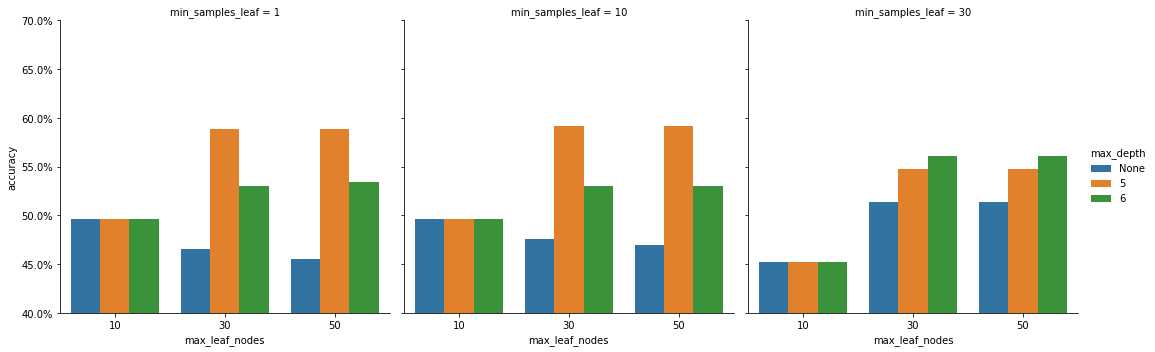

In [29]:
# specify axis
ax = sns.catplot(data = dt_results, 
                 x = 'max_leaf_nodes', 
                 hue = 'max_depth', 
                 col = 'min_samples_leaf',
                 y = 'accuracy', 
                 kind = 'bar',
                 ci = None);

# y axis limits
plt.ylim(0.40, 0.70)

# loop thru subplots & format axis as percentage
from  matplotlib.ticker import PercentFormatter
for subplot in ax.axes.flat:
    subplot.yaxis.set_major_formatter(PercentFormatter(1))

And our best model shows this as well, with the following hyper parameters:
- `max_leaf_nodes = 30`
- `min_samples_leaf = 10`
- `max_depth = 5`

With `accuracy = 59.2%`, there's certainly a bit to be desired (although keeping in mind that our data is synthetically balanced, which may result in a bit less variability to predict on then otherwise).

In [30]:
# winning model
dt_results.nlargest(1, ['accuracy']) 

,max_leaf_nodes,min_samples_leaf,max_depth,accuracy
0,30,10,5,0.591837


### Random Forest

We'll specify hyper parameters to tune our Random Forest model (ensemble method).

- `max_features`: max # of features included in each tree (default = 'sqrt')
- `min_samples_leaf`: min # of observations a node can have (default = 1)
- `max_depth`: max # of layers the tree can go to (default = unlimited)

In [31]:
# designate hyper param combinations to attempt
rf_hyper_space = {'max_features': ['sqrt', 0.5, 0.75],
                  'min_samples_leaf': [1, 10, 30],
                  'max_depth': [None, 5, 10]}

# crossjoin (cartesian product) to create array of dicts
rf_hypers = [dict(zip(rf_hyper_space, x)) for x in product(*rf_hyper_space.values())]

#### Tune model

We'll loop through each set of hyper parameters, fitting on the train data and predicting on the validation data. With a 3x3x3 tune-grid we'll be testing out 27 models.

When we initialize the random forest classifier, we'll specify to run on all processors (`n_jobs = -1`), with 50 trees in each forest (`n_estimators = 50`).

In each loop, we'll store the results and keep the model with the highest accuracy on the validation set.  This will take a bit longer than the Decision Tree model, but should still be relatively speedy.

In [32]:
# create empty df to store model results
rf_results = pd.DataFrame(columns=['max_features', 'min_samples_leaf', 'max_depth', 'accuracy'])

# loop through each set of hyper parameters
for hyper in rf_hypers:

    # initialize rf classifier (** to load dict as args)
    rf = rfc(n_jobs = -1, n_estimators = 50, verbose = False, random_state = random_state, **hyper)
    
    # fit classifier on train set
    rf.fit(X_train_reduced, y_train_smote)
    
    # make predictions on validation set (and calculate accuracy)
    y_valid_hat = rf.predict(X_valid_reduced)
    accuracy = accuracy_score(y_valid_smote, y_valid_hat)
    
    # store results in df
    rf_results = rf_results.append(pd.DataFrame({
        'max_features': hyper['max_features'], 
        'min_samples_leaf': hyper['min_samples_leaf'],
        'max_depth': hyper['max_depth'],
        'accuracy': [accuracy]
    }))

As above, we'll need to replace the `None` null values with the string `'None'` for vizualiations.

In [33]:
rf_results['max_depth'] = rf_results['max_depth'].fillna('None')

We'll visualize these results as well.

- As with our Decision Tree model, `max_depth` appears to have been the hyper parameter with the biggest impact on model accuracy (specifically at `max_depth = 5`).
- `max_features` and `min_samples_leaf` are a bit less consistent (depending on the hyper parameter combination), but using `'sqrt'` number of features does appear to have been the most predictive.

In general, it appears that sufficiently capping depth and the number of features performs best.

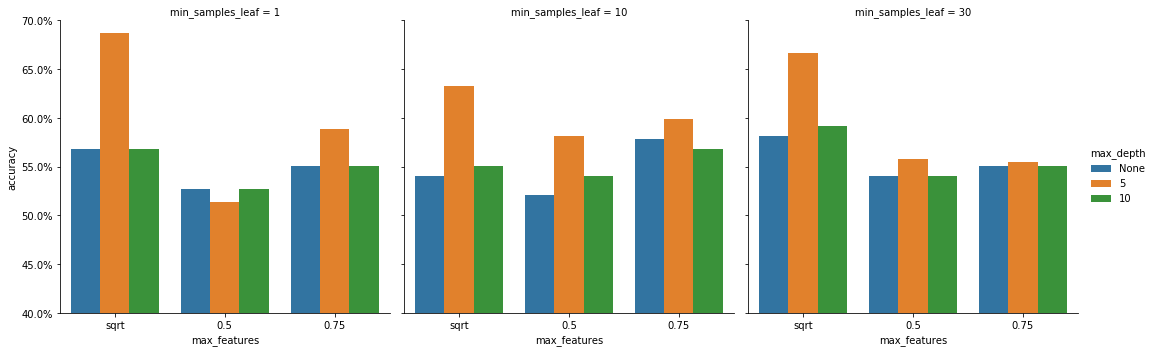

In [34]:
# specify axis
ax = sns.catplot(data = rf_results, 
                 x = 'max_features', 
                 hue = 'max_depth', 
                 col = 'min_samples_leaf',
                 y = 'accuracy', 
                 kind = 'bar',
                 ci = None);

# y axis limits
plt.ylim(0.4, 0.7)

# loop thru subplots & format axis as percentage
from  matplotlib.ticker import PercentFormatter
for subplot in ax.axes.flat:
    subplot.yaxis.set_major_formatter(PercentFormatter(1))

And our best model shows this as well, with the following hyper parameters:
- `max_features = 'sqrt'`
- `min_samples_leaf = 1`
- `max_depth = 5`

With `accuracy = 68.7%`, we see a marked improvement over our decision tree model.

In [35]:
# winning model
rf_results.nlargest(1, ['accuracy']) 

,max_features,min_samples_leaf,max_depth,accuracy
0,sqrt,1,5,0.687075


### SVM Classifier

We'll specify the following hyper parameters to tune our SVM classifier

- `kernel`: transformation function to fit to. Try linear, polynomial, and radial basis
- `degree`: polynomial degree to be used in the `'poly'` kernel.
- `C`: L2 regularization penalty
- `gamma`: coefficient for the `'poly'` and `'rbf'` kernel functions
    - Note: `gamma = 'auto'` uses *1 / nbr_features*. `gamma = 'scale'` uses *1 / (nbr_features * Var(X))*

In [36]:
# designate hyper param combinations to attempt
svm_hyper_space = {'kernel': ['linear', 'poly', 'rbf'], 
               'degree': [2, 3],
               'C': [5, 10, 15], 
               'gamma': ['scale', 'auto', 0.01]}

# crossjoin (cartesian product) to create array of dicts
svm_hypers = [dict(zip(svm_hyper_space, x)) for x in product(*svm_hyper_space.values())]

#### Tune model

Now we'll loop through each set of hyper parameters, fitting on the train data and making predictions on the validation data. With a 3x2x3x3 tune-grid we'll be testing out 54 models.  Note that we've already standardized our data earlier, so we can move ahead with model building/tuning. (SVM is a distance-sensitive algorithm)

When we initialize the SVM classifier, we'll specify our `random_state` for replicability.

As with our Decision Tree and Random Forest models, we'll store the results as we loop through to tune our hyper parameters.

**In total this should take 3-4 minutes to run.**

Also note that higher `gamma` values tend to be *much* more computationally expensive (at least in this model).  In a different environemnt, we would tune `gamma` across a broader range, but it proved too computationally intensive for this exercise.

In [37]:
# create empty df to store model results
svmc_results = pd.DataFrame(columns=['kernel', 'degree', 'C', 'gamma', 'accuracy'])

# loop through each set of hyper parameters
for hyper in svm_hypers:

    # initialize svm classifier (** to load dict as args)
    svmc = svm.SVC(random_state = random_state, **hyper)
    
    # fit classifier on train set
    svmc.fit(X_train_reduced, y_train_smote)
    
    # make predictions on validation set (and calculate accuracy)
    y_valid_hat = svmc.predict(X_valid_reduced)
    accuracy = accuracy_score(y_valid_smote, y_valid_hat)
    
    # store results in df
    svmc_results = svmc_results.append(pd.DataFrame({
        'kernel': hyper['kernel'], 
        'degree': hyper['degree'],
        'C': hyper['C'],
        'gamma': hyper['gamma'],
        'accuracy': [accuracy]
    }))

#### Visualize the results from hyper parameter tuning.

Specifically, we'll take a look at the `'linear'` and `'rbf'` kernel results first.

- In general, `'linear'` appears to perform a bit better, but the results are quite consistent across these hyper parameters.
- The regularization parameter (`C`) appears to have had very minimial affects on accuracy.
- The gamma parameter, would only affect the `'rbf'` kernel, but even there the effect is essentially neglible.

It's also worth noting that none of these models appears to have very good accuracy.  We'll inspect they `'polynomial'` kernel just below, but this may required some more computationally intensive hyper parameter tuning.

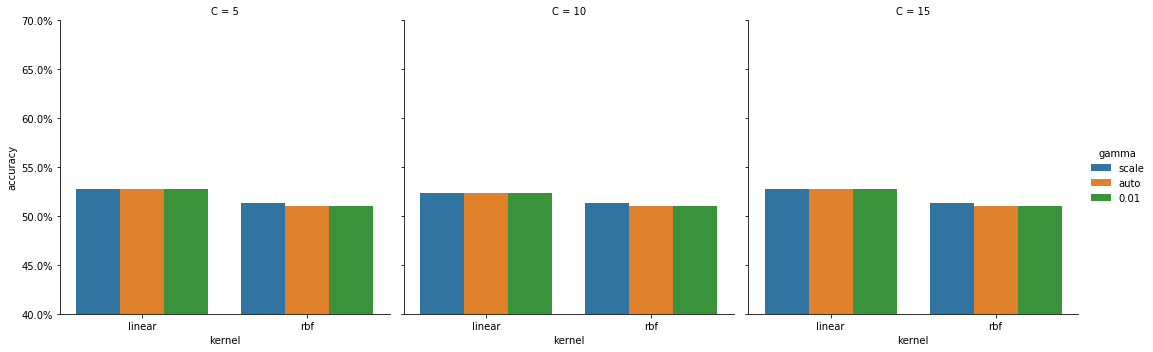

In [38]:
# specify axis
ax = sns.catplot(data = svmc_results[svmc_results['kernel']!='poly'], 
                 x = 'kernel', 
                 hue = 'gamma', 
                 col = 'C',
                 y = 'accuracy', 
                 kind = 'bar',
                 ci = None);

# y axis limits
plt.ylim(0.4, 0.70)

# loop thru subplots & format axis as percentage
from  matplotlib.ticker import PercentFormatter
for subplot in ax.axes.flat:
    subplot.yaxis.set_major_formatter(PercentFormatter(1))

We visualize the `'poly'` kernel separately so that we can also examine the effect of the `degree` parameter (which has no effect on the other kernel functions)

It appears that across the board, `degree = 3` results in a bit higher accuracy.  We also see a bit more variation in model performance across the other hyper parameters.

- `gamma == 'scale'` appears to perform a bit better for *low* regularization penalties (`C =  5`)
- `gamma != 'scale'` appears to perform a bit better for *high* regularization penalties (`C = 15`)

The poly kernel also results in relatively low accuracy, although it does appear a *bit* better than the other kernels (linear, rbf).

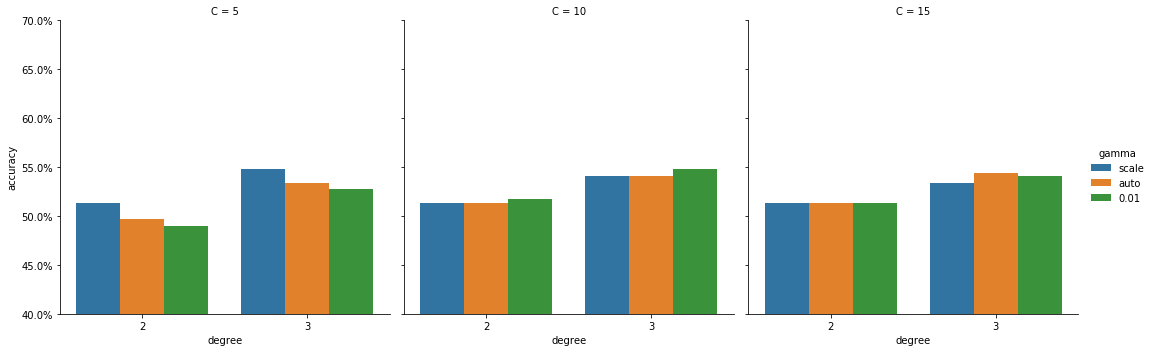

In [39]:
# specify axis
ax = sns.catplot(data = svmc_results[svmc_results['kernel']=='poly'], 
                 x = 'degree', 
                 hue = 'gamma', 
                 col = 'C',
                 y = 'accuracy', 
                 kind = 'bar',
                 ci = None);

# y axis limits
plt.ylim(0.4, 0.70)

# loop thru subplots & format axis as percentage
from  matplotlib.ticker import PercentFormatter
for subplot in ax.axes.flat:
    subplot.yaxis.set_major_formatter(PercentFormatter(1))

Our best model has the following hyper parameters:
- `kernel = 'poly'`
- `degree = 3`
- `C = 5`
- `gamme = 'scale'`

With `accuracy = 54.8%`, we are really left wanting more.  This model was outperformed by both the Random Forest *and* Decision Tree on our validation set.

In [40]:
# winning model
svmc_results.nlargest(1, ['accuracy']) 

,kernel,degree,C,gamma,accuracy
0,poly,3,5,scale,0.547619


## Evaluation of Models

We've compared each of our models on the validation set and saw that the Random Forest performed best (followed by the decision tree and then the SVM classifier).

**Based on validation performance, we make the decision to use the Random Forest model in production.**

That said, for informative purposes, we'll also evaluate each of the winning models on the test set, too.  Note that these results do not affect our decision to use the Random Forest model.

We'll start by initializing our best models and re-fitting to the balanced, reduced, standardized train data.

In [41]:
# best model: Decision Tree
tree = DecisionTreeClassifier(criterion = 'gini', 
                              random_state = random_state, 
                              max_leaf_nodes = 30,
                              min_samples_leaf = 10,
                              max_depth = 5)

# best model: Random Forest
rf = rfc(n_jobs = -1, 
         n_estimators = 50, 
         verbose = False, 
         random_state = random_state,
         max_features = 'sqrt',
         min_samples_leaf = 1,
         max_depth = 5)

# best model: SVM Classifier
svmc = svm.SVC(random_state = random_state,
               kernel = 'poly',
               degree = 3,
               C = 5,
               gamma = 'scale'
              )

# fit models
tree.fit(X_train_reduced, y_train_smote)
rf.fit(X_train_reduced, y_train_smote)
svmc.fit(X_train_reduced, y_train_smote)

SVC(C=5, kernel='poly', random_state=99)

And now we'll make and store our predictions on the **unbalanced** test data.  We do not balance our test data, because we want to understand accuracy expectations in production.

In [42]:
# make predictions on the test set
y_test_hat_tree = tree.predict(X_test_reduced)
y_test_hat_rf = rf.predict(X_test_reduced)
y_test_hat_svmc = svmc.predict(X_test_reduced)

In preparation for evaluation on Test set, we'll also define functions to clearly present the following:

- accuracy metrics (f1, precision, recall, etc)
- confusion matrix

In [43]:
def accuracy_report(y, y_hat):
    
    # store accuracy metrics (f1, precision, recall, accuracy, + full report)
    f1 = f1_score(y, y_hat, pos_label = 1)
    precision = precision_score(y, y_hat, pos_label = 1)
    recall = recall_score(y, y_hat, pos_label = 1)
    accuracy = accuracy_score(y, y_hat)
    class_rpt = classification_report(y, y_hat, zero_division = 0)
    
    # print accuracy measures
    print("f1: ", round(f1, 4))
    print("precision: ", round(precision, 4))
    print("recall: ", round(recall, 4))
    print("accuracy: ", round(accuracy, 4))
    print("==================================")
    print(class_rpt)

In [44]:
def format_cm(y, y_hat, title, labels, norm):
    ''' norm = { 'true', 'pred', 'all', None }'''
    
    # store (normalized) confusion matrix
    cm = np.round(confusion_matrix(y, y_hat, normalize = norm), 3)

    # configure confusion matrix plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # show plot and confusion matrix
    plt.show()
    print(cm)

#### Evaluate Accuracy Metrics

Taking a look at the accuracy metrics of each model, we actually see the Random Forest and SVM classifier have similar classification rates on both classes (albeit slightly better for the Random Forest model).

However, we also notice that while the Decision Tree model has the lowest overall accuracy, it *does* have the highest recall on the positive class (manufacturing failures). At `0.60` the recall is noticeably better than the other two models (`0.20` each).

The precision on the Decision Tree model is a *bit* lower on the positive class (`0.17`, as compared to `0.20` in RF), but not to an extreme degree.

Given the relatively low prevalance of failures, and the higher cost of missing a failure than "missing" a success... had we evaluated these metrics (precision, recall, f1) on the validation set, we'd have likely been inclined to choose the Decision Tree model!

**Decision Tree**

In [45]:
# accuracy metrics: Decision Tree
accuracy_report(y_test, y_test_hat_tree)

f1:  0.2667
precision:  0.1714
recall:  0.6
accuracy:  0.7898
              precision    recall  f1-score   support

          -1       0.97      0.80      0.88       147
           1       0.17      0.60      0.27        10

    accuracy                           0.79       157
   macro avg       0.57      0.70      0.57       157
weighted avg       0.92      0.79      0.84       157



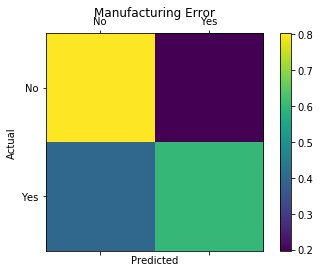

[[0.803 0.197]
 [0.4   0.6  ]]


In [46]:
# confusion matrix: Decision Tree
format_cm(y_test, y_test_hat_tree, "Manufacturing Error", ["No", "Yes"], "true")

**Random Forest**

In [47]:
# accuracy metrics
accuracy_report(y_test, y_test_hat_rf)

f1:  0.2
precision:  0.2
recall:  0.2
accuracy:  0.8981
              precision    recall  f1-score   support

          -1       0.95      0.95      0.95       147
           1       0.20      0.20      0.20        10

    accuracy                           0.90       157
   macro avg       0.57      0.57      0.57       157
weighted avg       0.90      0.90      0.90       157



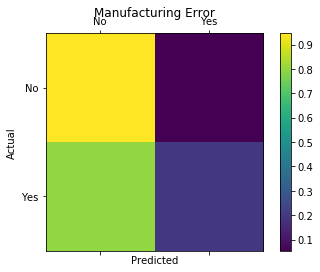

[[0.946 0.054]
 [0.8   0.2  ]]


In [48]:
# confusion matrix: Random Forest
format_cm(y_test, y_test_hat_rf, "Manufacturing Error", ["No", "Yes"], "true")

**SVM Classifier**

In [49]:
# accuracy metrics
accuracy_report(y_test, y_test_hat_svmc)

f1:  0.1818
precision:  0.1667
recall:  0.2
accuracy:  0.8854
              precision    recall  f1-score   support

          -1       0.94      0.93      0.94       147
           1       0.17      0.20      0.18        10

    accuracy                           0.89       157
   macro avg       0.56      0.57      0.56       157
weighted avg       0.90      0.89      0.89       157



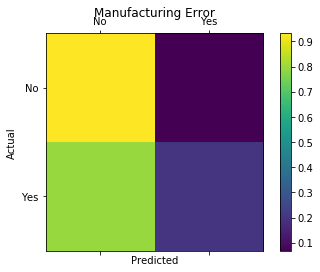

[[0.932 0.068]
 [0.8   0.2  ]]


In [50]:
# confusion matrix: SVM classifier
format_cm(y_test, y_test_hat_svmc, "Manufacturing Error", ["No", "Yes"], "true")

## Summary

Based on the overall accuracy on our validation set, we selected the Random Forest model for production.  However in the more thorough evaluation of our models on the test (using more balanced accuracy metrics, such as f1, recall, and precision), we discovered that this analysis should have also been applied to our model selection process on the validation data.

Our main goal with this model should be to identify as many defective products as possible, without overwhelming the Quality Check Team/Process.  By that criteria, the Decision Tree model performed best on the test data (highest positive recall, while maintaining positive precision).

In all likelihood, these accuracy findings were also present in the validation data as well, so taking that extra step before selecting your chosen model is important!

In the end, using the Random Forest model, we can expect overall accuracy of `89.8%`, and catching `20%` of all defects (with `20%` of flagged defects *actually* being defective).

Had we chosen the Decision Tree, we would've obtained an overall accuracy of `79%`, but catchin `60%` of all defects (with `17%` of flagged products actually being defective).